# Interpretabilidade e explicabilidade

Os alunos deverão explorar algum método de interpretação de modelos e/ou modelos naturalmente interpretáveis (por exemplo, árvores de decisão), a fim de compreender ou extrair hipóteses sobre quais atributos são aparentemente mais relevantes para a tarefa de predição e/ou como eles impactam na decisão do modelo. Sugere-se que se faça esta investigação apenas para um modelo, a ser escolhido com base no melhor desempenho preditivo em dados de teste (isto é, o melhor modelo conforme análise do grupo). Os grupos deverão incluir no relatório informações obtidas desta análise, como gráficos, tabelas, etc, e discutir a respeito das relações encontradas na análise que mais chamaram a atenção, seja pela pertinência da associação ou por ser um resultado inesperado.

## Setup

In [1]:
pip install pandas plotly matplotlib seaborn scikit-learn shap

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

from sklearn.inspection import permutation_importance

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import shap

/home/leonardoazzi/cic/24-2/ml/trabalho/student-dropout-prediction/src/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


https://machinelearningmastery.com/calculate-feature-importance-with-python/

You need to be using this version of scikit-learn or higher.
0.22.1

In [3]:
# check scikit-learn version
import sklearn
print(sklearn.__version__)

1.5.2


## Carregamento dos dados e configuração do modelo

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [4]:
data = pd.read_csv("./data/clean-dataset.csv")
X = data.drop('Target', axis=1)
y = data['Target']
print(X.shape, y.shape)

(4424, 20) (4424,)


In [5]:
# Algoritmos selecionados para otimização de hiperparâmetros

lr = LogisticRegression()
abc = AdaBoostClassifier()
svmachine = svm.SVC(probability=True)

algo_dict = {'Logistic Regression': lr, 'AdaBoost': abc, 'SVM': svmachine}

# Treinando o modelo em todo o dataset

# 2. Interpretabilidade intrínseca

**Interpretabilidade:** a capacidade de explicar ou apresentar em termos compreensíveis para um ser humano.

## Importância de atributos intríseca

- Método de obtenção da importância por coeficientes e árvores variam com o algortimo e viés indutivo de cada modelo
  - Logistic Regression/DecisionTree/RandomForest/XGBoost: https://machinelearningmastery.com/calculate-feature-importance-with-python/ 

In [6]:
# EXEMPLO: coeficientes da regressao logistica

# # logistic regression for feature importance
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from matplotlib import pyplot
# # define dataset
# X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# # define the model
# model = LogisticRegression()
# # fit the model
# model.fit(X, y)
# # get importance
# importance = model.coef_[0]
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

# 3. Interpretabilidade extrínseca

**Explicabilidade:** coleção de artefatos visuais e/ou interativos que fornecem ao usuário uma descrição suﬁciente do comportamento de
um modelo para executar com precisão tarefas como avaliação, conﬁança, previsão ou melhoria de um modelo.

**Explainable Machine learning:** análises post-hoc e técnicas usadas para entender os mecanismos para tomada de decisão ou as previsões realizadas pelo modelo treinado.

In [7]:
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=4, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

Carrega os hiperparâmetros selecionados

In [30]:
import ast

optimal_hyperparams = pd.read_csv("./data/otimizacao-hiperparams.csv")
result = optimal_hyperparams.iloc[2]
best_params = result.iloc[0]
display(optimal_hyperparams)

# Convert the string representation of the dictionary to an actual dictionary
best_params_dict = ast.literal_eval(best_params)
print(best_params_dict)

,11
0,AdaBoost
1,1
2,"{'Modelo__n_estimators': 364, 'Modelo__learnin..."
3,0.7962085308056872
4,0.75
5,0.8484848484848485
6,0.910191967064005


{'Modelo__n_estimators': 364, 'Modelo__learning_rate': 0.11209664263972449}


Treina para todos os dados

In [31]:
model = make_pipeline(model=algo_dict['AdaBoost'])
model.set_params(Modelo__n_estimators = best_params_dict['Modelo__n_estimators'],
                         Modelo__learning_rate = best_params_dict['Modelo__learning_rate'])

model.fit(X, y)

/home/leonardoazzi/cic/24-2/ml/trabalho/student-dropout-prediction/src/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Pipeline(steps=[('Feature Selection',
                 SelectKBest(k=4,
                             score_func=<function mutual_info_classif at 0x75e6914edf30>)),
                ('Normalização', StandardScaler()),
                ('Balanceamento da classe minoritária',
                 SMOTE(sampling_strategy='minority')),
                ('Modelo',
                 AdaBoostClassifier(learning_rate=0.11209664263972449,
                                    n_estimators=364))])

## Importância de Atributos

- Método de importância de atributos com **testes de permutação é model agnostic**
  - https://machinelearningmastery.com/calculate-feature-importance-with-python/
  - https://scikit-learn.org/stable/modules/permutation_importance.html

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. **Consider running the example a few times and compare the average outcome.**

Questões
- Devemos usar pipeline?
  - https://stackoverflow.com/questions/62106204/permutation-importance-using-a-pipeline-in-scikit-learn
- Como importar os hiperparâmetros otimizados?

In [32]:
column_indices = {column: index for index, column in enumerate(data.columns)}
print(column_indices)

{'Marital status': 0, 'Application mode': 1, 'Application order': 2, 'Course': 3, 'Daytime/evening attendance': 4, 'Previous qualification': 5, "Mother's qualification": 6, "Mother's occupation": 7, 'Displaced': 8, 'Educational special needs': 9, 'Debtor': 10, 'Tuition fees up to date': 11, 'Gender': 12, 'Scholarship holder': 13, 'International': 14, 'Curricular units 2nd sem (grade)': 15, 'Curricular units 2nd sem (without evaluations)': 16, 'Unemployment rate': 17, 'Inflation rate': 18, 'GDP': 19, 'Target': 20}


Feature: 0, Score: 0.00000
Feature: 1, Score: 0.01462
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.01642
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.09547
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.25647
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000


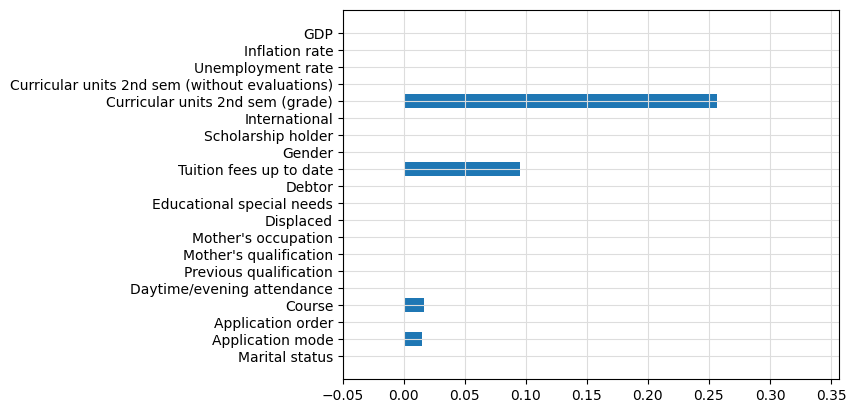

In [33]:
# perform permutation importance
results = permutation_importance(model, X, y, scoring='f1')
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
ax = plt.barh([x for x in range(len(importance))], importance)

# Show the major grid and style it slightly.
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

# Fixa o eixo x do gráfico
plt.xlim(-0.05, max(importance) + 0.1)
plt.yticks(ticks=range(len(importance)), labels=[column for column in list(column_indices.keys())[:len(importance)]], rotation=0)

plt.show()


## SHAP

https://github.com/shap/shap


Usando o KernelExplainer, por ser mais agnóstico a modelos, pois o pacote não suporta o AdaBoost diretamente. https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/model_agnostic/Simple%20Kernel%20SHAP.html#Using-KernelExplainer

In [34]:
# # Transform the data using the pipeline's feature selection and scaling steps
# X_transformed = model.named_steps['Normalização'].transform(model.named_steps['Feature Selection'].transform(X))

# # Use SHAP to explain the model's predictions
# explainer = shap.KernelExplainer(model.named_steps['Modelo'].predict, X_transformed)
# shap_values = explainer.shap_values(X_transformed)

# # Plot the SHAP values
# shap.summary_plot(shap_values, X_transformed)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

Demora bastante para usar o KernelExplainer do SHAP

https://github.com/ModelOriented/DALEX/issues/366

## PDP
https://scikit-learn.org/stable/modules/partial_dependence.html

IDP: unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample. Due to the limits of human perception, only one input feature of interest is supported for ICE plots. While the PDPs are good at showing the average effect of the target features, they can obscure a heterogeneous relationship created by interactions.


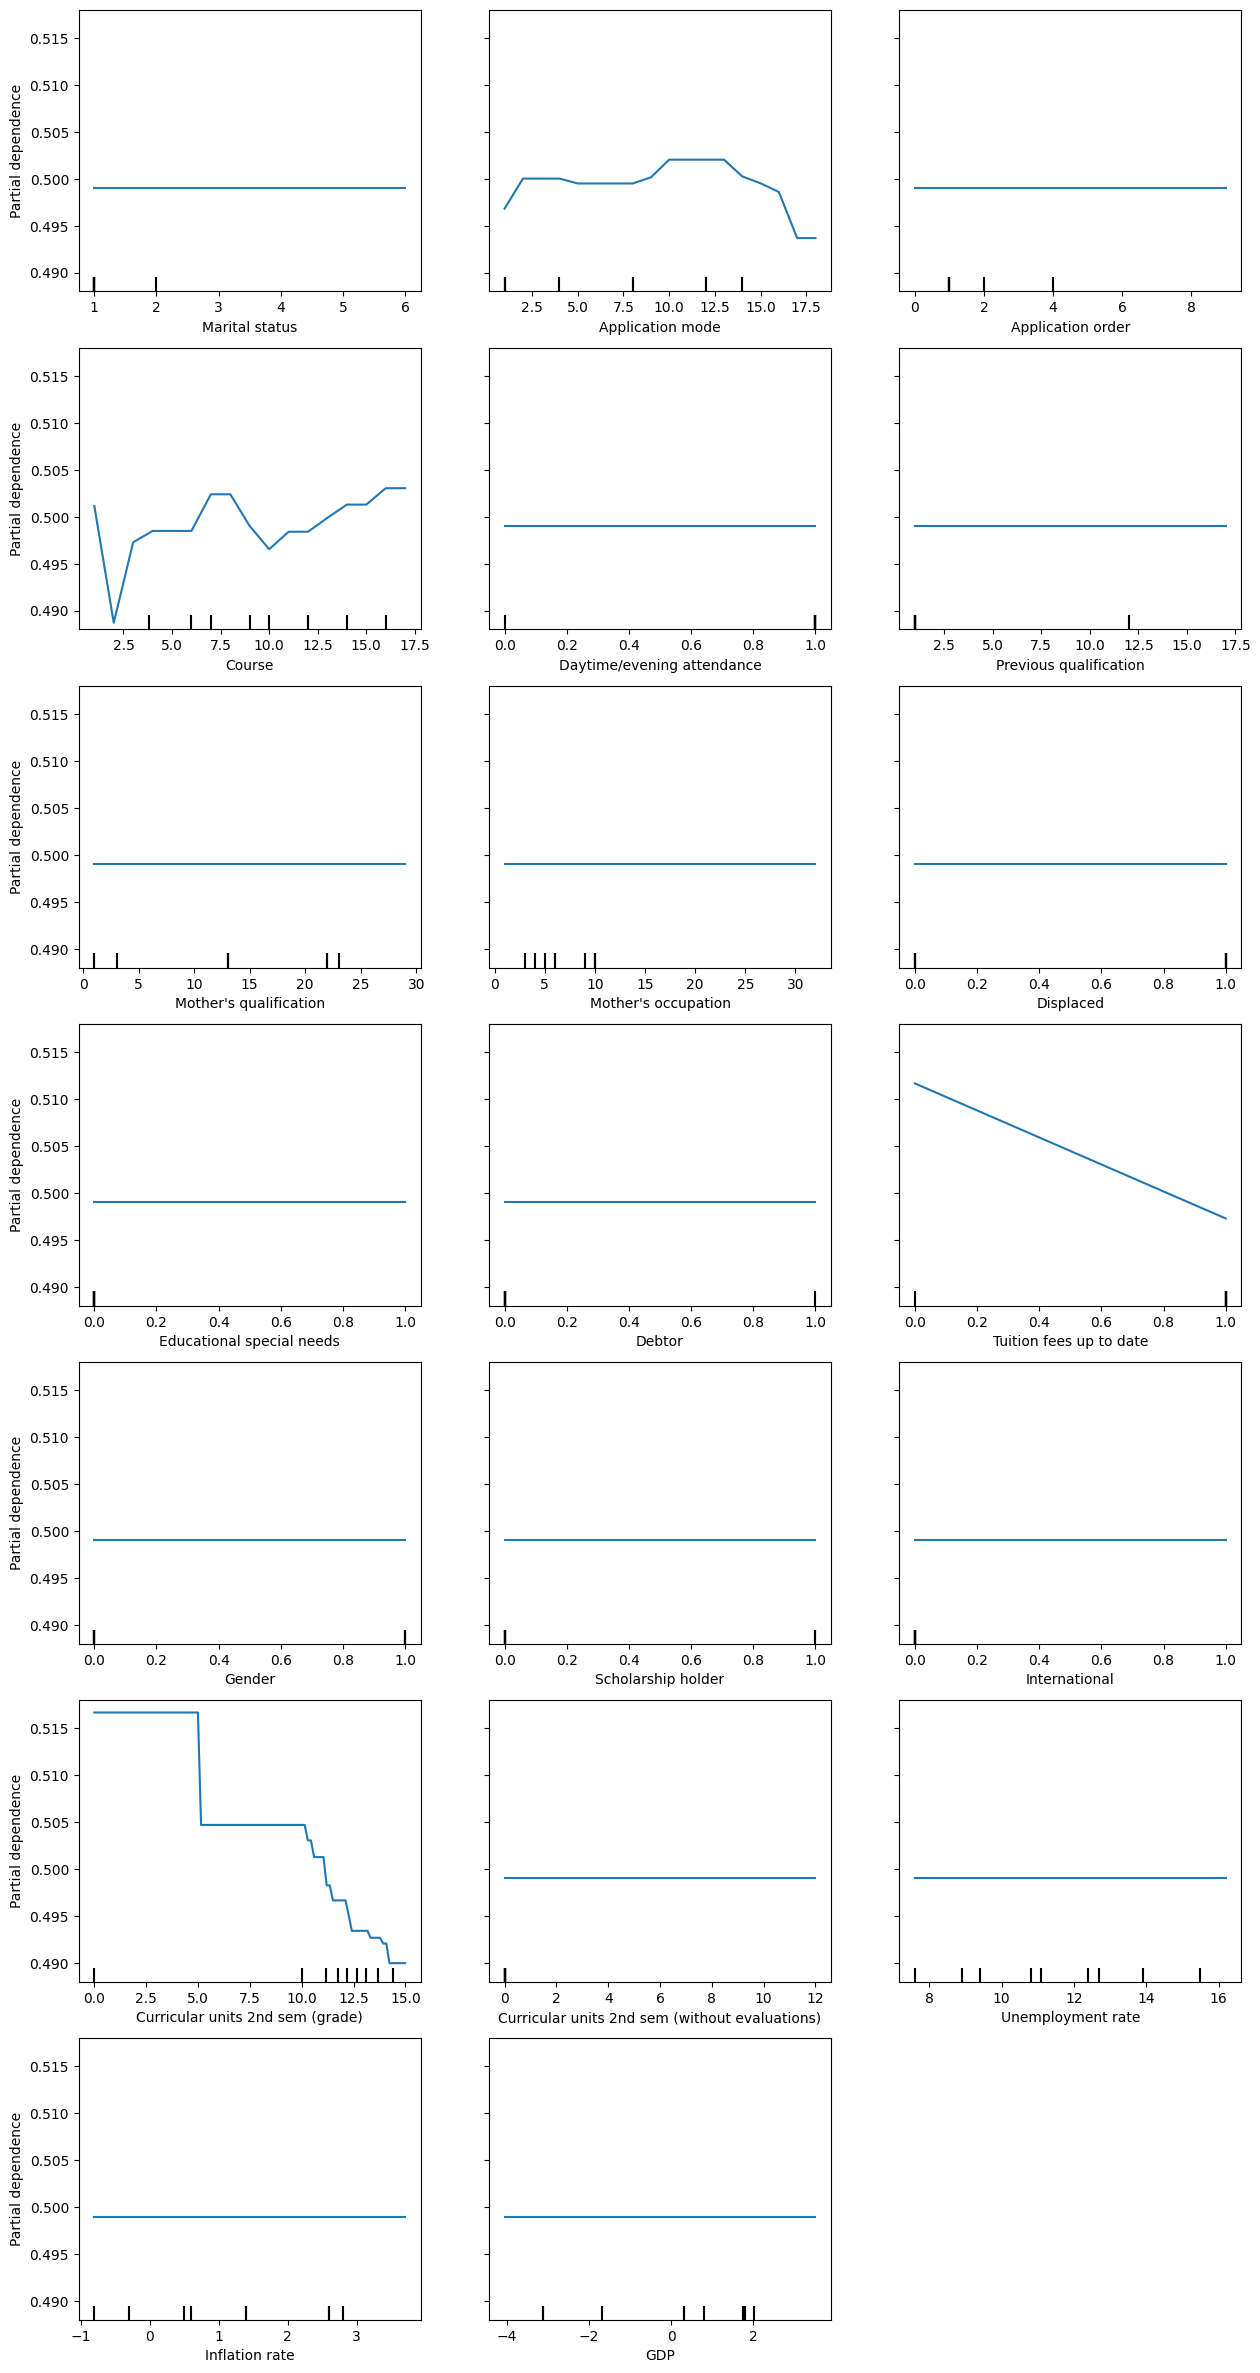

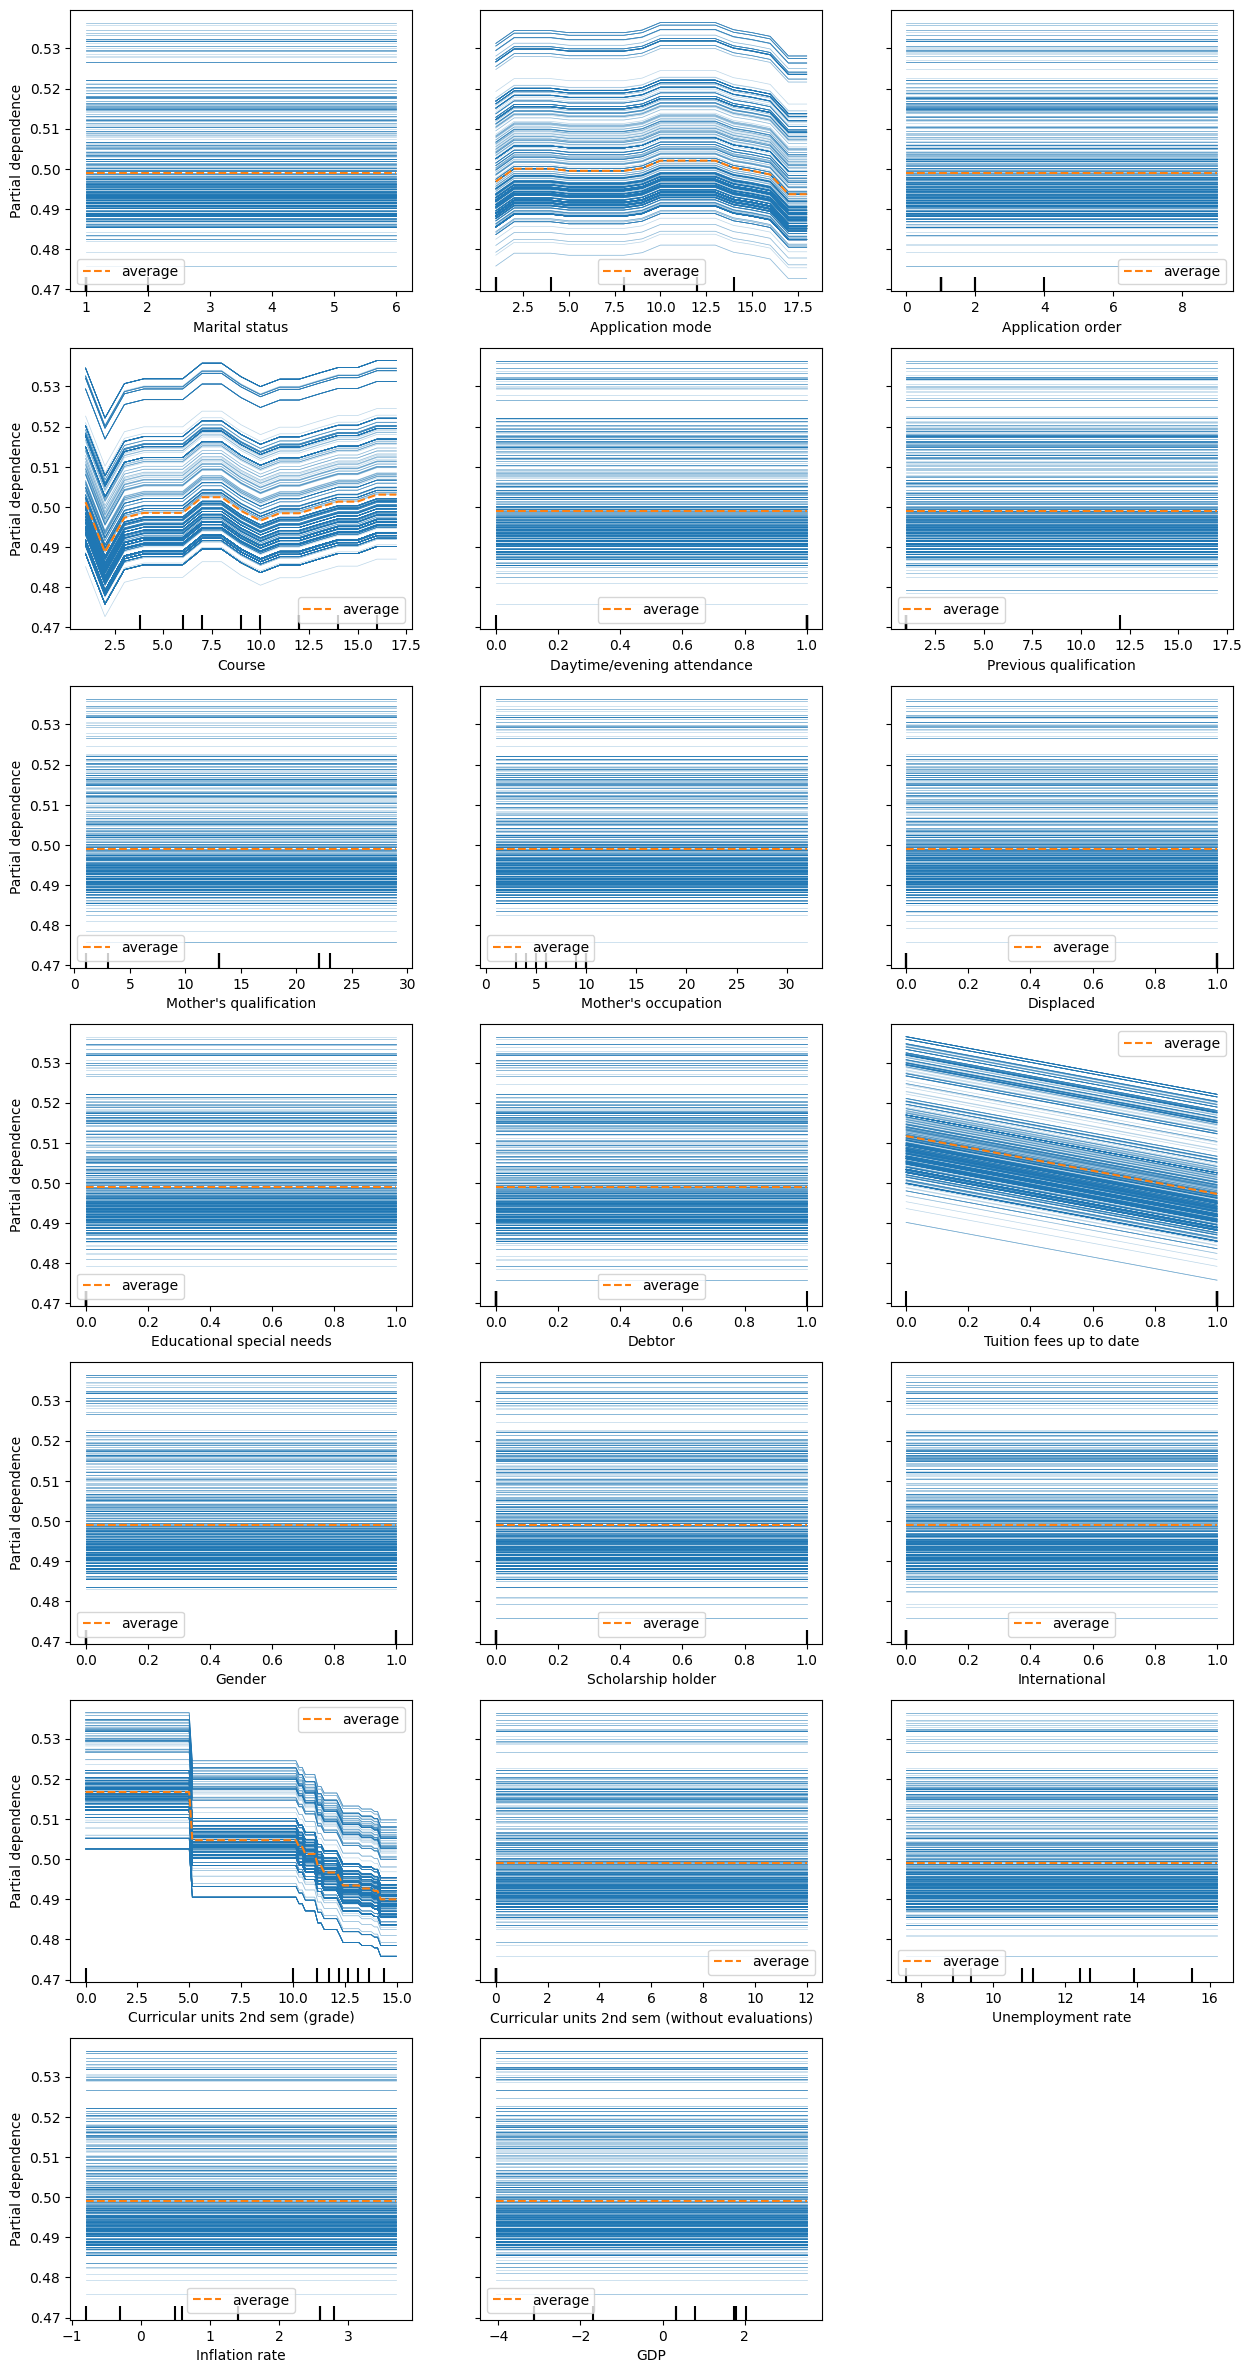

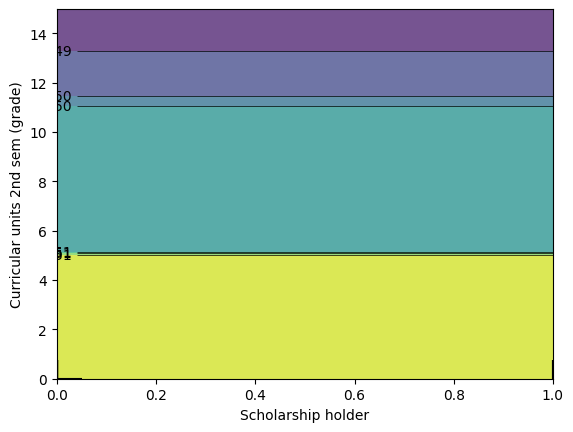

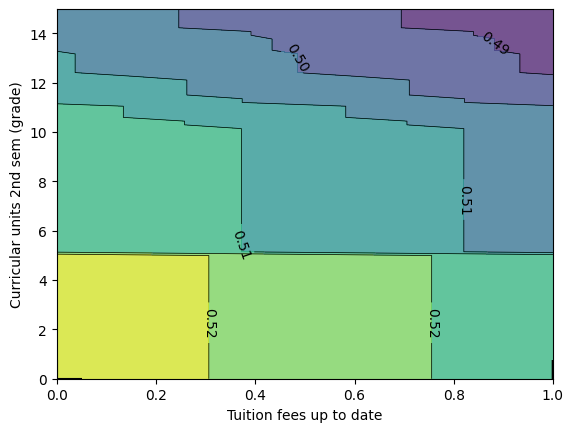

In [35]:
from sklearn.inspection import PartialDependenceDisplay

# One-way Partial Dependence Plot
# ==================================
features = list(range(20)) # Índices dos atributos que serão plotados

PartialDependenceDisplay.from_estimator(model, X, features, n_cols=3)
plt.gcf().set_size_inches(15, 30)

PartialDependenceDisplay.from_estimator(model, X, features, n_cols=3, kind='both')
plt.gcf().set_size_inches(15, 30)

# Two-way Partial Dependence Plot
# ==================================

# Grade 2nd sem vs. Scholarship holder
features = [(13,15)]
PartialDependenceDisplay.from_estimator(model, X, features)

# Tuition Fees Up to Date vs. Grade 2nd sem
features = [(11,15)]
PartialDependenceDisplay.from_estimator(model, X, features)